# GeoGuessr Machine Learning-Ansatz

## Zusatzinformationen

In [1]:
base_dir = '/home/fhase/Desktop/Dataset_S'

## Code

### Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Imports für Deep Learning
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, ReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import cv2
import os

2023-04-10 20:05:54.886482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 20:05:55.423361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Functions

In [3]:
def get_data(labels, appendix, cnt, img_size):
    data = [] 
    for label in labels: 
        internCounter = cnt/len(labels);
        path = os.path.join(base_dir, label, appendix, 'images')
        class_num = labels.index(label)
        for img in os.listdir(path):
            if(internCounter <= 0):
                break;
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = list(cv2.resize(img_arr, (img_size, img_size))) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
            internCounter = internCounter -1
    return data

In [4]:
def split_train_val(train, val, img_size):
    x_train = []
    y_train = []
    x_val = []
    y_val = []

    for feature, label in train:
        x_train.append(feature)
        y_train.append(label)

    for feature, label in val:
        x_val.append(feature)
        y_val.append(label)

    # Normalize the data
    x_train = np.array(x_train) / 255
    x_val = np.array(x_val) / 255

    x_train.reshape(-1, img_size, img_size, 1)
    y_train = np.array(y_train)

    x_val.reshape(-1, img_size, img_size, 1)
    y_val = np.array(y_val)
    
    return x_train, y_train, x_val, y_val

In [5]:
def generate_model(img_size, layers):
    model = Sequential()
    
    for layer in layers:
        model.add(layer)
    
    return model

In [6]:
def train_model(model, learning_rate, x_train, y_train, x_val, y_val, epoch_range):
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])

    history = model.fit(x_train,y_train,epochs = epoch_range , validation_data = (x_val, y_val))
    
    return model, history

In [7]:
def plot_history(history, epoch_range):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epoch_range)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt

def plot_history_from_xlsx(epoch_range, acc, val_acc, loss, val_loss):
    epochs_range = range(epoch_range)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt
    

In [8]:
def get_metrics(model, labels, x_val, y_val):
    predictionOdds = model.predict(x_val)
    predictions = []
    for pred in predictionOdds:
        predictions.append(list(pred).index(max(pred)))

    predictions = np.array(predictions)
    predictions = predictions.reshape(1,-1)[0]
    return classification_report(y_val, predictions, target_names = labels)

In [9]:
def run_neural_network(img_size, processed_images, train_split, labels, epoch_range, learning_rate, layers):
    train_images = int(processed_images * train_split)
    val_images = int(processed_images - train_images)
    
    train = get_data(labels, 'database', train_images, img_size)
    val = get_data(labels, 'query', val_images, img_size)
                  
    x_train, y_train, x_val, y_val = split_train_val(train, val, img_size)
    
    model = generate_model(img_size, layers)
    print(model.summary())
    
    model, history = train_model(model, learning_rate, x_train, y_train, x_val, y_val, epoch_range)
    
    metrics = get_metrics(model, labels, x_val, y_val)
    
    return history, metrics

In [10]:
def load_results():
    resultPath = os.path.join(base_dir, 'NeuralNetwork_Results.xlsx') 
    return pd.read_excel(resultPath)

In [11]:
def show_results(results, rowId, epochs):
    result = results.loc[rowId]
    
    acc = eval(result['Train Acc'])[:epochs]
    val_acc = eval(result['Val Acc'])[:epochs]
    loss = eval(result['Train Loss'])[:epochs]
    val_loss = eval(result['Val Loss'])[:epochs]
    
    return plot_history_from_xlsx(epochs, acc, val_acc, loss, val_loss)

In [12]:
def main():
    resultPath = os.path.join(base_dir, 'NeuralNetwork_Results.xlsx')
    cities = ['berlin', 'kampala', 'melbourne', 'saopaulo', 'sf', 'tokyo']
    image_count = [100, 1000, 1250] # alles >1500 crasht wegen memory overflow
    resolution = [244, 450, 1000]
    learning_rate = [0.000001, 0.00001, 0.0001]
    epoch_range = 100
    
    results = pd.DataFrame(columns=['ID', 'Netzwerk', 'Anzahl Städte', 'Anzahl Bilder', 'Bildauflösung (px)', 'Lernquote', 
                                    'Train Acc', 'Val Acc', 'Train Loss', 'Val Loss', 'Metriken'])
    results = results.set_index('ID')
    rowId = 0
    
    for i, lastCity in enumerate(cities):
        if(i == 0): 
            continue
        for images in image_count:
            for res in resolution:
                if images > 1000 and res > 450:
                    continue
                for lr in learning_rate:
                    # needs res for initialization
                    network1 = [Conv2D(32,3,padding="same", activation="relu", input_shape = (res,res,3)), 
                        Conv2D(32,3, padding="same", activation="relu"), 
                        MaxPool2D(),
                        ReLU(),
                        Conv2D(64,3, padding="same", activation="relu"),
                        MaxPool2D(),
                        Flatten(),
                        Dense(128,activation="relu"), 
                        Dense(len(cities), activation="softmax")
                    ]
                    # network2 = [Conv2D(32,3,padding="same", activation="relu", input_shape=(res, res, 3)), 
                    #                 MaxPool2D(), Conv2D(32, 3, padding="same", activation="relu"), MaxPool2D(), 
                    #                 Conv2D(64, 3, padding="same", activation="relu"), MaxPool2D(), Dropout(0.4), Flatten(), 
                    #                 Dense(128,activation="relu"), Dense(len(cities), activation="softmax")]
                    networks = [network1]
                    for j, network in enumerate(networks):
                        try:
                            history, metrics = run_neural_network(res, images, 0.8, cities[:i+1], epoch_range, lr, network)
                        
                            results.loc[rowId] = ['Netzwerk ' + str(j+1), i+1, images, res, lr, history.history['accuracy'],
                                              history.history['val_accuracy'], history.history['loss'],
                                              history.history['val_loss'], metrics]
                        except:
                            print("Error on network" + str(j+1) + ":\n\timageCnt: " + str(images) + "\n\tresolution: " + str(res))
                            results.loc[rowId] = ['Netzwerk ' + str(j+1), i+1, images, res, lr, "",
                                              "", "",
                                              "", ""]
                        rowId = rowId + 1
    try:
        results.to_excel(resultPath)
    except:
        print("Didn't write to file!")
    return results # safe path if write doesn't work

### Execute Neural Network

In [13]:
main()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 244, 244, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 244, 244, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 32)     0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 122, 122, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                    

2023-04-10 20:05:56.483641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-10 20:05:56.500317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-10 20:05:56.500510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

None
Epoch 1/100


2023-04-10 20:05:58.254728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-10 20:05:58.734917: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-10 20:05:58.735460: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-10 20:05:58.735475: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-10 20:05:58.735881: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-10 20:05:58.735917: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

3/3 [==============================] - 6s 865ms/step - loss: 1.7732 - accuracy: 0.0375 - val_loss: 1.7237 - val_accuracy: 0.3500
Epoch 2/100
3/3 [==============================] - 0s 60ms/step - loss: 1.7160 - accuracy: 0.3875 - val_loss: 1.6679 - val_accuracy: 0.6000
Epoch 3/100
3/3 [==============================] - 0s 61ms/step - loss: 1.6610 - accuracy: 0.5375 - val_loss: 1.6130 - val_accuracy: 0.6500
Epoch 4/100
3/3 [==============================] - 0s 62ms/step - loss: 1.6055 - accuracy: 0.5875 - val_loss: 1.5590 - val_accuracy: 0.7500
Epoch 5/100
3/3 [==============================] - 0s 60ms/step - loss: 1.5524 - accuracy: 0.6125 - val_loss: 1.5059 - val_accuracy: 0.7500
Epoch 6/100
3/3 [==============================] - 0s 61ms/step - loss: 1.4994 - accuracy: 0.6250 - val_loss: 1.4539 - val_accuracy: 0.7500
Epoch 7/100
3/3 [==============================] - 0s 60ms/step - loss: 1.4477 - accuracy: 0.6375 - val_loss: 1.4035 - val_accuracy: 0.7500
Epoch 8/100
3/3 [==============

3/3 [==============================] - 0s 59ms/step - loss: 0.6197 - accuracy: 0.9125 - val_loss: 0.6570 - val_accuracy: 0.8000
Epoch 60/100
3/3 [==============================] - 0s 60ms/step - loss: 0.6151 - accuracy: 0.9125 - val_loss: 0.6536 - val_accuracy: 0.8000
Epoch 61/100
3/3 [==============================] - 0s 60ms/step - loss: 0.6107 - accuracy: 0.9125 - val_loss: 0.6500 - val_accuracy: 0.8000
Epoch 62/100
3/3 [==============================] - 0s 60ms/step - loss: 0.6063 - accuracy: 0.9125 - val_loss: 0.6467 - val_accuracy: 0.8000
Epoch 63/100
3/3 [==============================] - 0s 60ms/step - loss: 0.6020 - accuracy: 0.9125 - val_loss: 0.6433 - val_accuracy: 0.8000
Epoch 64/100
3/3 [==============================] - 0s 60ms/step - loss: 0.5987 - accuracy: 0.9125 - val_loss: 0.6400 - val_accuracy: 0.8000
Epoch 65/100
3/3 [==============================] - 0s 60ms/step - loss: 0.5938 - accuracy: 0.9125 - val_loss: 0.6370 - val_accuracy: 0.8000
Epoch 66/100
3/3 [========

3/3 [==============================] - 0s 60ms/step - loss: 1.0682 - accuracy: 0.5125 - val_loss: 1.0011 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 0s 59ms/step - loss: 0.9578 - accuracy: 0.5000 - val_loss: 0.9202 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 59ms/step - loss: 0.8674 - accuracy: 0.5000 - val_loss: 0.8468 - val_accuracy: 0.7000
Epoch 7/100
3/3 [==============================] - 0s 60ms/step - loss: 0.8033 - accuracy: 0.7125 - val_loss: 0.7972 - val_accuracy: 0.4500
Epoch 8/100
3/3 [==============================] - 0s 59ms/step - loss: 0.7533 - accuracy: 0.8750 - val_loss: 0.7636 - val_accuracy: 0.5000
Epoch 9/100
3/3 [==============================] - 0s 60ms/step - loss: 0.7173 - accuracy: 0.9125 - val_loss: 0.7378 - val_accuracy: 0.5000
Epoch 10/100
3/3 [==============================] - 0s 61ms/step - loss: 0.6852 - accuracy: 0.8625 - val_loss: 0.7198 - val_accuracy: 0.7000
Epoch 11/100
3/3 [=============

3/3 [==============================] - 0s 60ms/step - loss: 0.1611 - accuracy: 0.9875 - val_loss: 0.4985 - val_accuracy: 0.7500
Epoch 63/100
3/3 [==============================] - 0s 62ms/step - loss: 0.1561 - accuracy: 0.9875 - val_loss: 0.5084 - val_accuracy: 0.7500
Epoch 64/100
3/3 [==============================] - 0s 60ms/step - loss: 0.1537 - accuracy: 0.9875 - val_loss: 0.5134 - val_accuracy: 0.7500
Epoch 65/100
3/3 [==============================] - 0s 60ms/step - loss: 0.1483 - accuracy: 0.9875 - val_loss: 0.4925 - val_accuracy: 0.7500
Epoch 66/100
3/3 [==============================] - 0s 60ms/step - loss: 0.1436 - accuracy: 0.9875 - val_loss: 0.4904 - val_accuracy: 0.7500
Epoch 67/100
3/3 [==============================] - 0s 59ms/step - loss: 0.1393 - accuracy: 0.9875 - val_loss: 0.5023 - val_accuracy: 0.7500
Epoch 68/100
3/3 [==============================] - 0s 61ms/step - loss: 0.1350 - accuracy: 1.0000 - val_loss: 0.5189 - val_accuracy: 0.7500
Epoch 69/100
3/3 [========

3/3 [==============================] - 0s 60ms/step - loss: 0.3197 - accuracy: 0.9375 - val_loss: 0.4868 - val_accuracy: 0.8000
Epoch 8/100
3/3 [==============================] - 0s 60ms/step - loss: 0.2763 - accuracy: 0.9250 - val_loss: 0.5396 - val_accuracy: 0.6500
Epoch 9/100
3/3 [==============================] - 0s 61ms/step - loss: 0.2030 - accuracy: 0.9750 - val_loss: 0.4708 - val_accuracy: 0.8000
Epoch 10/100
3/3 [==============================] - 0s 60ms/step - loss: 0.1866 - accuracy: 0.9500 - val_loss: 0.4735 - val_accuracy: 0.7500
Epoch 11/100
3/3 [==============================] - 0s 60ms/step - loss: 0.1491 - accuracy: 1.0000 - val_loss: 0.5315 - val_accuracy: 0.7000
Epoch 12/100
3/3 [==============================] - 0s 61ms/step - loss: 0.1161 - accuracy: 0.9875 - val_loss: 0.4425 - val_accuracy: 0.8000
Epoch 13/100
3/3 [==============================] - 0s 60ms/step - loss: 0.1073 - accuracy: 0.9875 - val_loss: 0.4979 - val_accuracy: 0.7500
Epoch 14/100
3/3 [==========

3/3 [==============================] - 0s 61ms/step - loss: 2.2701e-04 - accuracy: 1.0000 - val_loss: 0.9440 - val_accuracy: 0.7000
Epoch 65/100
3/3 [==============================] - 0s 60ms/step - loss: 2.1511e-04 - accuracy: 1.0000 - val_loss: 0.9656 - val_accuracy: 0.7000
Epoch 66/100
3/3 [==============================] - 0s 60ms/step - loss: 2.0587e-04 - accuracy: 1.0000 - val_loss: 0.9983 - val_accuracy: 0.7000
Epoch 67/100
3/3 [==============================] - 0s 60ms/step - loss: 1.9383e-04 - accuracy: 1.0000 - val_loss: 0.9909 - val_accuracy: 0.7000
Epoch 68/100
3/3 [==============================] - 0s 60ms/step - loss: 1.8482e-04 - accuracy: 1.0000 - val_loss: 0.9956 - val_accuracy: 0.7000
Epoch 69/100
3/3 [==============================] - 0s 61ms/step - loss: 1.7687e-04 - accuracy: 1.0000 - val_loss: 0.9953 - val_accuracy: 0.7000
Epoch 70/100
3/3 [==============================] - 0s 61ms/step - loss: 1.7062e-04 - accuracy: 1.0000 - val_loss: 1.0149 - val_accuracy: 0.700

2023-04-10 20:07:03.859508: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-10 20:07:04.402941: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-10 20:07:04.402985: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-10 20:07:06.386448: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

3/3 [==============================] - 13s 3s/step - loss: 1.7039 - accuracy: 0.3500 - val_loss: 1.5588 - val_accuracy: 0.5500
Epoch 2/100
3/3 [==============================] - 1s 181ms/step - loss: 1.5032 - accuracy: 0.5500 - val_loss: 1.4027 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 1s 182ms/step - loss: 1.3439 - accuracy: 0.5250 - val_loss: 1.2697 - val_accuracy: 0.5000
Epoch 4/100
3/3 [==============================] - 1s 181ms/step - loss: 1.2123 - accuracy: 0.5000 - val_loss: 1.1599 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 1s 181ms/step - loss: 1.1030 - accuracy: 0.5000 - val_loss: 1.0713 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 1s 181ms/step - loss: 1.0159 - accuracy: 0.5125 - val_loss: 1.0021 - val_accuracy: 0.5000
Epoch 7/100
3/3 [==============================] - 1s 182ms/step - loss: 0.9455 - accuracy: 0.5125 - val_loss: 0.9465 - val_accuracy: 0.5000
Epoch 8/100
3/3 [==========

Epoch 59/100
3/3 [==============================] - 1s 183ms/step - loss: 0.3644 - accuracy: 0.9500 - val_loss: 0.6026 - val_accuracy: 0.7000
Epoch 60/100
3/3 [==============================] - 1s 180ms/step - loss: 0.3592 - accuracy: 0.9500 - val_loss: 0.5977 - val_accuracy: 0.7500
Epoch 61/100
3/3 [==============================] - 1s 183ms/step - loss: 0.3548 - accuracy: 0.9375 - val_loss: 0.5920 - val_accuracy: 0.7500
Epoch 62/100
3/3 [==============================] - 1s 181ms/step - loss: 0.3503 - accuracy: 0.9375 - val_loss: 0.5887 - val_accuracy: 0.6500
Epoch 63/100
3/3 [==============================] - 1s 182ms/step - loss: 0.3476 - accuracy: 0.9625 - val_loss: 0.5861 - val_accuracy: 0.6500
Epoch 64/100
3/3 [==============================] - 1s 181ms/step - loss: 0.3432 - accuracy: 0.9625 - val_loss: 0.5847 - val_accuracy: 0.7500
Epoch 65/100
3/3 [==============================] - 1s 182ms/step - loss: 0.3374 - accuracy: 0.9750 - val_loss: 0.5866 - val_accuracy: 0.7500
Epoch 

Epoch 4/100
3/3 [==============================] - 1s 181ms/step - loss: 0.6606 - accuracy: 0.5750 - val_loss: 0.6097 - val_accuracy: 0.7000
Epoch 5/100
3/3 [==============================] - 1s 183ms/step - loss: 0.5918 - accuracy: 0.7000 - val_loss: 0.6037 - val_accuracy: 0.7000
Epoch 6/100
3/3 [==============================] - 1s 182ms/step - loss: 0.5746 - accuracy: 0.7125 - val_loss: 0.5764 - val_accuracy: 0.7500
Epoch 7/100
3/3 [==============================] - 1s 184ms/step - loss: 0.5276 - accuracy: 0.8125 - val_loss: 0.5716 - val_accuracy: 0.8000
Epoch 8/100
3/3 [==============================] - 1s 183ms/step - loss: 0.5011 - accuracy: 0.8500 - val_loss: 0.5429 - val_accuracy: 0.8000
Epoch 9/100
3/3 [==============================] - 1s 184ms/step - loss: 0.4761 - accuracy: 0.9000 - val_loss: 0.5344 - val_accuracy: 0.7500
Epoch 10/100
3/3 [==============================] - 1s 182ms/step - loss: 0.4480 - accuracy: 0.9250 - val_loss: 0.5289 - val_accuracy: 0.7500
Epoch 11/100

Epoch 62/100
3/3 [==============================] - 1s 183ms/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.5425 - val_accuracy: 0.7500
Epoch 63/100
3/3 [==============================] - 1s 185ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.5324 - val_accuracy: 0.7500
Epoch 64/100
3/3 [==============================] - 1s 181ms/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.5648 - val_accuracy: 0.7500
Epoch 65/100
3/3 [==============================] - 1s 183ms/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.5934 - val_accuracy: 0.7000
Epoch 66/100
3/3 [==============================] - 1s 182ms/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 0.6097 - val_accuracy: 0.7000
Epoch 67/100
3/3 [==============================] - 1s 182ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.5832 - val_accuracy: 0.7000
Epoch 68/100
3/3 [==============================] - 1s 181ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.5796 - val_accuracy: 0.7000
Epoch 

3/3 [==============================] - 1s 182ms/step - loss: 4.3151 - accuracy: 0.5000 - val_loss: 4.9475 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 1s 182ms/step - loss: 2.2600 - accuracy: 0.6000 - val_loss: 5.4958 - val_accuracy: 0.5000
Epoch 4/100
3/3 [==============================] - 1s 180ms/step - loss: 5.0466 - accuracy: 0.5000 - val_loss: 3.5624 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 1s 182ms/step - loss: 1.6887 - accuracy: 0.5750 - val_loss: 2.1696 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 1s 176ms/step - loss: 1.9039 - accuracy: 0.5000 - val_loss: 1.4109 - val_accuracy: 0.5500
Epoch 7/100
3/3 [==============================] - 1s 181ms/step - loss: 0.7957 - accuracy: 0.6125 - val_loss: 1.1747 - val_accuracy: 0.6500
Epoch 8/100
3/3 [==============================] - 1s 183ms/step - loss: 0.6837 - accuracy: 0.6625 - val_loss: 0.6720 - val_accuracy: 0.7000
Epoch 9/100
3/3 [========

3/3 [==============================] - 1s 183ms/step - loss: 2.5535e-04 - accuracy: 1.0000 - val_loss: 0.8727 - val_accuracy: 0.7500
Epoch 60/100
3/3 [==============================] - 1s 182ms/step - loss: 2.4106e-04 - accuracy: 1.0000 - val_loss: 0.8821 - val_accuracy: 0.7500
Epoch 61/100
3/3 [==============================] - 1s 184ms/step - loss: 2.2883e-04 - accuracy: 1.0000 - val_loss: 0.8840 - val_accuracy: 0.7500
Epoch 62/100
3/3 [==============================] - 1s 182ms/step - loss: 2.1683e-04 - accuracy: 1.0000 - val_loss: 0.8966 - val_accuracy: 0.7500
Epoch 63/100
3/3 [==============================] - 1s 183ms/step - loss: 2.0481e-04 - accuracy: 1.0000 - val_loss: 0.9144 - val_accuracy: 0.7500
Epoch 64/100
3/3 [==============================] - 1s 182ms/step - loss: 1.9487e-04 - accuracy: 1.0000 - val_loss: 0.9113 - val_accuracy: 0.7500
Epoch 65/100
3/3 [==============================] - 1s 183ms/step - loss: 1.8550e-04 - accuracy: 1.0000 - val_loss: 0.9027 - val_accuracy

2023-04-10 20:10:12.628065: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:10:12.628090: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:10:12.628100: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 91, Chunks in use: 90. 22.8KiB allocated for chunks. 22.5KiB in use in bin. 4.1KiB client-requested in use in bin.
2023-04-10 20:10:12.628107: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 8, Chunks in use: 7. 4.5KiB allocated for chunks. 3.8KiB in use in bin. 3.6KiB client-requested in use in bin.
2023-04-10 20:10:12.628113: I tensorflow/tsl/framework/bfc_al

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:10:23.597413: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:10:23.597441: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:10:23.597450: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 91, Chunks in use: 90. 22.8KiB allocated for chunks. 22.5KiB in use in bin. 4.1KiB client-requested in use in bin.
2023-04-10 20:10:23.597457: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 8, Chunks in use: 7. 4.5KiB allocated for chunks. 3.8KiB in use in bin. 3.6KiB client-requested in use in bin.
2023-04-10 20:10:23.597463: I tensorflow/tsl/framework/bfc_al

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:10:34.572887: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:10:34.572914: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:10:34.572922: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 94, Chunks in use: 93. 23.5KiB allocated for chunks. 23.2KiB in use in bin. 4.6KiB client-requested in use in bin.
2023-04-10 20:10:34.572927: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 7, Chunks in use: 7. 3.8KiB allocated for chunks. 3.8KiB in use in bin. 3.6KiB client-requested in use in bin.
2023-04-10 20:10:34.572932: I tensorflow/tsl/framework/bfc_al

Error on network1:
	imageCnt: 100
	resolution: 1000
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 244, 244, 32)      896       
                                                                 
 conv2d_28 (Conv2D)          (None, 244, 244, 32)      9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 122, 122, 32)     0         
 g2D)                                                            
                                                                 
 re_lu_9 (ReLU)              (None, 122, 122, 32)      0         
                                                                 
 conv2d_29 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 61, 61, 64)       0         
 g

Epoch 46/100
25/25 [==============================] - 2s 60ms/step - loss: 0.3537 - accuracy: 0.8775 - val_loss: 0.4355 - val_accuracy: 0.8250
Epoch 47/100
25/25 [==============================] - 2s 60ms/step - loss: 0.3485 - accuracy: 0.8775 - val_loss: 0.4366 - val_accuracy: 0.8250
Epoch 48/100
25/25 [==============================] - 2s 61ms/step - loss: 0.3463 - accuracy: 0.8788 - val_loss: 0.4292 - val_accuracy: 0.8350
Epoch 49/100
25/25 [==============================] - 2s 61ms/step - loss: 0.3419 - accuracy: 0.8813 - val_loss: 0.4303 - val_accuracy: 0.8300
Epoch 50/100
25/25 [==============================] - 2s 61ms/step - loss: 0.3396 - accuracy: 0.8800 - val_loss: 0.4203 - val_accuracy: 0.8350
Epoch 51/100
25/25 [==============================] - 2s 60ms/step - loss: 0.3351 - accuracy: 0.8737 - val_loss: 0.4362 - val_accuracy: 0.8250
Epoch 52/100
25/25 [==============================] - 2s 61ms/step - loss: 0.3316 - accuracy: 0.8838 - val_loss: 0.4219 - val_accuracy: 0.8400

                                                                 
 conv2d_31 (Conv2D)          (None, 244, 244, 32)      9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 122, 122, 32)     0         
 g2D)                                                            
                                                                 
 re_lu_10 (ReLU)             (None, 122, 122, 32)      0         
                                                                 
 conv2d_32 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 238144)            0         
                                                                 
 dense_20 

25/25 [==============================] - 2s 61ms/step - loss: 0.0542 - accuracy: 0.9975 - val_loss: 0.5236 - val_accuracy: 0.8250
Epoch 49/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0538 - accuracy: 0.9962 - val_loss: 0.5510 - val_accuracy: 0.8250
Epoch 50/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0486 - accuracy: 0.9987 - val_loss: 0.5430 - val_accuracy: 0.8250
Epoch 51/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0469 - accuracy: 0.9987 - val_loss: 0.5889 - val_accuracy: 0.8300
Epoch 52/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0456 - accuracy: 0.9987 - val_loss: 0.4984 - val_accuracy: 0.8400
Epoch 53/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0483 - accuracy: 0.9975 - val_loss: 0.5982 - val_accuracy: 0.8300
Epoch 54/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0402 - accuracy: 0.9987 - val_loss: 0.5233 - val_accuracy: 0.8400
Epoch 55/100

                                                                 
 re_lu_11 (ReLU)             (None, 122, 122, 32)      0         
                                                                 
 conv2d_35 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 238144)            0         
                                                                 
 dense_22 (Dense)            (None, 128)               30482560  
                                                                 
 dense_23 (Dense)            (None, 6)                 774       
                                                                 
Total params: 30,511,974
Trainable params: 30,511,974
Non-trainable params: 

Epoch 50/100
25/25 [==============================] - 2s 61ms/step - loss: 1.4779e-04 - accuracy: 1.0000 - val_loss: 1.2906 - val_accuracy: 0.8200
Epoch 51/100
25/25 [==============================] - 2s 61ms/step - loss: 1.4452e-04 - accuracy: 1.0000 - val_loss: 1.2813 - val_accuracy: 0.8200
Epoch 52/100
25/25 [==============================] - 2s 61ms/step - loss: 1.3633e-04 - accuracy: 1.0000 - val_loss: 1.2924 - val_accuracy: 0.8200
Epoch 53/100
25/25 [==============================] - 2s 61ms/step - loss: 1.2556e-04 - accuracy: 1.0000 - val_loss: 1.2982 - val_accuracy: 0.8200
Epoch 54/100
25/25 [==============================] - 2s 61ms/step - loss: 1.2013e-04 - accuracy: 1.0000 - val_loss: 1.2968 - val_accuracy: 0.8200
Epoch 55/100
25/25 [==============================] - 2s 61ms/step - loss: 1.1574e-04 - accuracy: 1.0000 - val_loss: 1.2870 - val_accuracy: 0.8100
Epoch 56/100
25/25 [==============================] - 2s 61ms/step - loss: 1.1061e-04 - accuracy: 1.0000 - val_loss: 1

 re_lu_12 (ReLU)             (None, 225, 225, 32)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 225, 225, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 802816)            0         
                                                                 
 dense_24 (Dense)            (None, 128)               102760576 
                                                                 
 dense_25 (Dense)            (None, 6)                 774       
                                                                 
Total params: 102,789,990
Trainable params: 102,789,990
Non-trainable params: 0
______________________________________________________________

2023-04-10 20:18:45.464655: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 791.02MiB (rounded to 829440000)requested by op sequential_12/conv2d_36/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:18:45.464683: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:18:45.464690: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 205, Chunks in use: 205. 51.2KiB allocated for chunks. 51.2KiB in use in bin. 11.6KiB client-requested in use in bin.
2023-04-10 20:18:45.464696: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 19, Chunks in use: 19. 9.8KiB allocated for chunks. 9.8KiB in use in bin. 9.6KiB client-requested in use in bin.
2023-04-10 20:18:45.464700: I te

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:19:01.047820: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:19:01.047844: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:19:01.047851: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 206, Chunks in use: 206. 51.5KiB allocated for chunks. 51.5KiB in use in bin. 11.8KiB client-requested in use in bin.
2023-04-10 20:19:01.047857: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 19, Chunks in use: 19. 9.8KiB allocated for chunks. 9.8KiB in use in bin. 9.6KiB client-requested in use in bin.
2023-04-10 20:19:01.047861: I tensor

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:19:16.497529: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:19:16.497557: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:19:16.497564: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 206, Chunks in use: 206. 51.5KiB allocated for chunks. 51.5KiB in use in bin. 11.8KiB client-requested in use in bin.
2023-04-10 20:19:16.497569: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 19, Chunks in use: 19. 9.8KiB allocated for chunks. 9.8KiB in use in bin. 9.6KiB client-requested in use in bin.
2023-04-10 20:19:16.497574: I tensor

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:19:35.389895: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:19:35.389919: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:19:35.389926: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 209, Chunks in use: 209. 52.2KiB allocated for chunks. 52.2KiB in use in bin. 12.3KiB client-requested in use in bin.
2023-04-10 20:19:35.389931: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 19, Chunks in use: 19. 9.8KiB allocated for chunks. 9.8KiB in use in bin. 9.6KiB client-requested in use in bin.
2023-04-10 20:19:35.389935: I tensorf

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:19:54.483668: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:19:54.483695: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:19:54.483702: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 209, Chunks in use: 209. 52.2KiB allocated for chunks. 52.2KiB in use in bin. 12.3KiB client-requested in use in bin.
2023-04-10 20:19:54.483707: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 19, Chunks in use: 19. 9.8KiB allocated for chunks. 9.8KiB in use in bin. 9.6KiB client-requested in use in bin.
2023-04-10 20:19:54.483712: I tensorf

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:20:13.445226: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:20:13.445255: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:20:13.445263: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 212, Chunks in use: 212. 53.0KiB allocated for chunks. 53.0KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:20:13.445268: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 19, Chunks in use: 19. 9.8KiB allocated for chunks. 9.8KiB in use in bin. 9.6KiB client-requested in use in bin.
2023-04-10 20:20:13.445272: I tensorf

Error on network1:
	imageCnt: 1000
	resolution: 1000
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 244, 244, 32)      896       
                                                                 
 conv2d_55 (Conv2D)          (None, 244, 244, 32)      9248      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 122, 122, 32)     0         
 g2D)                                                            
                                                                 
 re_lu_18 (ReLU)             (None, 122, 122, 32)      0         
                                                                 
 conv2d_56 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 61, 61, 64)       0         


2023-04-10 20:20:29.294403: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 681.33MiB (rounded to 714432000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:20:29.294433: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:20:29.294443: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 213, Chunks in use: 213. 53.2KiB allocated for chunks. 53.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:20:29.294450: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 20, Chunks in use: 20. 10.2KiB allocated for chunks. 10.2KiB in use in bin. 10.1KiB client-requested in use in bin.
2023-04-10 20:20:29.294456: I tensorflow/tsl/f

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 244, 244, 32)      896       
                                                                 
 conv2d_58 (Conv2D)          (None, 244, 244, 32)      9248      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 122, 122, 32)     0         
 g2D)                                                            
                                                                 
 re_lu_19 (ReLU)             (None, 122, 122, 32)      0         
                                                                 
 conv2d_59 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                

2023-04-10 20:20:45.027358: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 681.33MiB (rounded to 714432000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:20:45.027392: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:20:45.027400: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 217, Chunks in use: 217. 54.2KiB allocated for chunks. 54.2KiB in use in bin. 13.3KiB client-requested in use in bin.
2023-04-10 20:20:45.027405: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.0KiB allocated for chunks. 11.0KiB in use in bin. 10.6KiB client-requested in use in bin.
2023-04-10 20:20:45.027409: I tensorflow/tsl/f


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 244, 244, 32)      896       
                                                                 
 conv2d_61 (Conv2D)          (None, 244, 244, 32)      9248      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 122, 122, 32)     0         
 g2D)                                                            
                                                                 
 re_lu_20 (ReLU)             (None, 122, 122, 32)      0         
                                                                 
 conv2d_62 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                               

2023-04-10 20:21:00.761251: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 681.33MiB (rounded to 714432000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:21:00.761280: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:21:00.761287: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 217, Chunks in use: 217. 54.2KiB allocated for chunks. 54.2KiB in use in bin. 13.3KiB client-requested in use in bin.
2023-04-10 20:21:00.761292: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.0KiB allocated for chunks. 11.0KiB in use in bin. 10.6KiB client-requested in use in bin.
2023-04-10 20:21:00.761297: I tensorflow/tsl/f

2023-04-10 20:21:17.478844: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:21:17.478873: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:21:17.478880: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 220, Chunks in use: 220. 55.0KiB allocated for chunks. 55.0KiB in use in bin. 13.8KiB client-requested in use in bin.
2023-04-10 20:21:17.478885: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.0KiB allocated for chunks. 11.0KiB in use in bin. 10.6KiB client-requested in use in bin.
2023-04-10 20:21:17.478890: I ten

Error on network1:
	imageCnt: 1250
	resolution: 450


2023-04-10 20:21:34.180702: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:21:34.180729: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:21:34.180737: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 220, Chunks in use: 220. 55.0KiB allocated for chunks. 55.0KiB in use in bin. 13.8KiB client-requested in use in bin.
2023-04-10 20:21:34.180742: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.0KiB allocated for chunks. 11.0KiB in use in bin. 10.6KiB client-requested in use in bin.
2023-04-10 20:21:34.180746: I ten

Error on network1:
	imageCnt: 1250
	resolution: 450


2023-04-10 20:21:50.755155: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:21:50.755186: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:21:50.755193: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 223, Chunks in use: 223. 55.8KiB allocated for chunks. 55.8KiB in use in bin. 14.3KiB client-requested in use in bin.
2023-04-10 20:21:50.755199: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 21. 11.8KiB allocated for chunks. 11.0KiB in use in bin. 10.6KiB client-requested in use in bin.
2023-04-10 20:21:50.755203: I ten

Error on network1:
	imageCnt: 1250
	resolution: 450
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 244, 244, 32)      896       
                                                                 
 conv2d_73 (Conv2D)          (None, 244, 244, 32)      9248      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 122, 122, 32)     0         
 g2D)                                                            
                                                                 
 re_lu_24 (ReLU)             (None, 122, 122, 32)      0         
                                                                 
 conv2d_74 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 61, 61, 64)       0         
 

2023-04-10 20:22:01.667413: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 232.56MiB (rounded to 243859456)requested by op sequential_24/conv2d_72/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:22:01.667442: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:22:01.667451: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 246, Chunks in use: 245. 61.5KiB allocated for chunks. 61.2KiB in use in bin. 15.8KiB client-requested in use in bin.
2023-04-10 20:22:01.667456: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:22:01.667461: I

Error on network1:
	imageCnt: 100
	resolution: 244


2023-04-10 20:22:12.213546: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:22:12.213574: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:22:12.213583: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 245, Chunks in use: 245. 61.2KiB allocated for chunks. 61.2KiB in use in bin. 16.0KiB client-requested in use in bin.
2023-04-10 20:22:12.213590: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:22:12.213596: I ten

Error on network1:
	imageCnt: 100
	resolution: 244


2023-04-10 20:22:22.739984: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:22:22.740013: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:22:22.740023: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 248, Chunks in use: 248. 62.0KiB allocated for chunks. 62.0KiB in use in bin. 16.5KiB client-requested in use in bin.
2023-04-10 20:22:22.740030: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:22:22.740036: I ten

Error on network1:
	imageCnt: 100
	resolution: 244


2023-04-10 20:22:33.371674: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:22:33.371707: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:22:33.371723: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 251, Chunks in use: 251. 62.8KiB allocated for chunks. 62.8KiB in use in bin. 17.0KiB client-requested in use in bin.
2023-04-10 20:22:33.371731: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:22:33.371737: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:22:44.018871: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:22:44.018900: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:22:44.018908: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 254, Chunks in use: 254. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 17.5KiB client-requested in use in bin.
2023-04-10 20:22:44.018915: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:22:44.018920: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:22:54.706527: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:22:54.706557: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:22:54.706564: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 248, Chunks in use: 248. 62.0KiB allocated for chunks. 62.0KiB in use in bin. 16.5KiB client-requested in use in bin.
2023-04-10 20:22:54.706570: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:22:54.706574: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:23:05.704589: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:23:05.704622: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:23:05.704638: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 251, Chunks in use: 251. 62.8KiB allocated for chunks. 62.8KiB in use in bin. 17.0KiB client-requested in use in bin.
2023-04-10 20:23:05.704645: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 26, Chunks in use: 25. 14.0KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:23:05.704652: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:23:16.715516: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:23:16.715547: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:23:16.715563: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 254, Chunks in use: 254. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 17.5KiB client-requested in use in bin.
2023-04-10 20:23:16.715572: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:23:16.715578: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:23:27.714445: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:23:27.714474: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:23:27.714492: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 257, Chunks in use: 257. 64.2KiB allocated for chunks. 64.2KiB in use in bin. 18.0KiB client-requested in use in bin.
2023-04-10 20:23:27.714499: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:23:27.714505: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:23:41.892894: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:23:41.892923: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:23:41.892930: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 251, Chunks in use: 251. 62.8KiB allocated for chunks. 62.8KiB in use in bin. 17.0KiB client-requested in use in bin.
2023-04-10 20:23:41.892936: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 26, Chunks in use: 25. 14.0KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:23:41.892940: I ten

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:23:56.093167: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:23:56.093199: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:23:56.093206: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 254, Chunks in use: 254. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 17.5KiB client-requested in use in bin.
2023-04-10 20:23:56.093212: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:23:56.093216: I ten

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:24:10.321829: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:24:10.321860: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:24:10.321867: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 254, Chunks in use: 254. 63.5KiB allocated for chunks. 63.5KiB in use in bin. 17.5KiB client-requested in use in bin.
2023-04-10 20:24:10.321873: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:24:10.321877: I ten

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:24:25.584177: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:24:25.584205: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:24:25.584212: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 257, Chunks in use: 257. 64.2KiB allocated for chunks. 64.2KiB in use in bin. 18.0KiB client-requested in use in bin.
2023-04-10 20:24:25.584217: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:24:25.584221: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:24:40.936298: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:24:40.936328: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:24:40.936335: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 260, Chunks in use: 260. 65.0KiB allocated for chunks. 65.0KiB in use in bin. 18.5KiB client-requested in use in bin.
2023-04-10 20:24:40.936341: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:24:40.936345: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:24:56.004358: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:24:56.004383: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:24:56.004390: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 257, Chunks in use: 257. 64.2KiB allocated for chunks. 64.2KiB in use in bin. 18.0KiB client-requested in use in bin.
2023-04-10 20:24:56.004396: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:24:56.004400: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:25:14.736236: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:25:14.736265: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:25:14.736273: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 260, Chunks in use: 260. 65.0KiB allocated for chunks. 65.0KiB in use in bin. 18.5KiB client-requested in use in bin.
2023-04-10 20:25:14.736278: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:25:14.736283: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:25:33.541865: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:25:33.541901: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:25:33.541910: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 260, Chunks in use: 260. 65.0KiB allocated for chunks. 65.0KiB in use in bin. 18.5KiB client-requested in use in bin.
2023-04-10 20:25:33.541915: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:25:33.541919: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:25:52.347235: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:25:52.347265: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:25:52.347280: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 263, Chunks in use: 263. 65.8KiB allocated for chunks. 65.8KiB in use in bin. 19.0KiB client-requested in use in bin.
2023-04-10 20:25:52.347288: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:25:52.347294: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:26:07.694751: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:26:07.694779: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:26:07.694786: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 263, Chunks in use: 263. 65.8KiB allocated for chunks. 65.8KiB in use in bin. 19.0KiB client-requested in use in bin.
2023-04-10 20:26:07.694792: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:26:07.694796: I ten

Error on network1:
	imageCnt: 1250
	resolution: 244


2023-04-10 20:26:22.986770: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:26:22.986805: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:26:22.986816: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 266, Chunks in use: 266. 66.5KiB allocated for chunks. 66.5KiB in use in bin. 19.5KiB client-requested in use in bin.
2023-04-10 20:26:22.986824: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 26, Chunks in use: 25. 13.8KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:26:22.986831: I ten

Error on network1:
	imageCnt: 1250
	resolution: 244


2023-04-10 20:26:38.285257: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:26:38.285288: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:26:38.285295: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 266, Chunks in use: 266. 66.5KiB allocated for chunks. 66.5KiB in use in bin. 19.5KiB client-requested in use in bin.
2023-04-10 20:26:38.285301: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 26, Chunks in use: 25. 13.8KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:26:38.285305: I ten

Error on network1:
	imageCnt: 1250
	resolution: 244


2023-04-10 20:26:54.796678: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:26:54.796703: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:26:54.796710: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 269, Chunks in use: 269. 67.2KiB allocated for chunks. 67.2KiB in use in bin. 20.0KiB client-requested in use in bin.
2023-04-10 20:26:54.796715: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:26:54.796720: I ten

Error on network1:
	imageCnt: 1250
	resolution: 450


2023-04-10 20:27:11.221369: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:27:11.221408: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:27:11.221419: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 269, Chunks in use: 269. 67.2KiB allocated for chunks. 67.2KiB in use in bin. 20.0KiB client-requested in use in bin.
2023-04-10 20:27:11.221427: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:27:11.221442: I ten

Error on network1:
	imageCnt: 1250
	resolution: 450


2023-04-10 20:27:27.648028: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:27:27.648056: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:27:27.648063: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 272, Chunks in use: 272. 68.0KiB allocated for chunks. 68.0KiB in use in bin. 20.5KiB client-requested in use in bin.
2023-04-10 20:27:27.648068: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:27:27.648072: I ten

Error on network1:
	imageCnt: 1250
	resolution: 450


2023-04-10 20:27:38.212742: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:27:38.212772: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:27:38.212779: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 275, Chunks in use: 275. 68.8KiB allocated for chunks. 68.8KiB in use in bin. 21.0KiB client-requested in use in bin.
2023-04-10 20:27:38.212784: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:27:38.212789: I ten

Error on network1:
	imageCnt: 100
	resolution: 244


2023-04-10 20:27:48.748231: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:27:48.748262: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:27:48.748269: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 272, Chunks in use: 272. 68.0KiB allocated for chunks. 68.0KiB in use in bin. 20.5KiB client-requested in use in bin.
2023-04-10 20:27:48.748274: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 26, Chunks in use: 25. 14.0KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:27:48.748279: I ten

Error on network1:
	imageCnt: 100
	resolution: 244


2023-04-10 20:27:59.285702: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:27:59.285730: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:27:59.285738: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 275, Chunks in use: 275. 68.8KiB allocated for chunks. 68.8KiB in use in bin. 21.0KiB client-requested in use in bin.
2023-04-10 20:27:59.285743: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:27:59.285748: I ten

Error on network1:
	imageCnt: 100
	resolution: 244


2023-04-10 20:28:09.932734: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:28:09.932764: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:28:09.932772: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 278, Chunks in use: 278. 69.5KiB allocated for chunks. 69.5KiB in use in bin. 21.5KiB client-requested in use in bin.
2023-04-10 20:28:09.932777: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:28:09.932782: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:28:20.556711: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:28:20.556746: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:28:20.556754: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 282, Chunks in use: 281. 70.5KiB allocated for chunks. 70.2KiB in use in bin. 22.0KiB client-requested in use in bin.
2023-04-10 20:28:20.556759: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:28:20.556764: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:28:31.189356: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:28:31.189388: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:28:31.189396: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 275, Chunks in use: 275. 68.8KiB allocated for chunks. 68.8KiB in use in bin. 21.0KiB client-requested in use in bin.
2023-04-10 20:28:31.189402: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 26, Chunks in use: 25. 14.0KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:28:31.189406: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:28:42.164535: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:28:42.164564: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:28:42.164572: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 278, Chunks in use: 278. 69.5KiB allocated for chunks. 69.5KiB in use in bin. 21.5KiB client-requested in use in bin.
2023-04-10 20:28:42.164578: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:28:42.164582: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:28:53.158349: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:28:53.158376: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:28:53.158384: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 282, Chunks in use: 281. 70.5KiB allocated for chunks. 70.2KiB in use in bin. 22.0KiB client-requested in use in bin.
2023-04-10 20:28:53.158389: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:28:53.158394: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:29:04.147008: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:29:04.147040: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:29:04.147049: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 284, Chunks in use: 284. 71.0KiB allocated for chunks. 71.0KiB in use in bin. 22.5KiB client-requested in use in bin.
2023-04-10 20:29:04.147054: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:29:04.147059: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:29:18.316173: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:29:18.316204: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:29:18.316211: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 278, Chunks in use: 278. 69.5KiB allocated for chunks. 69.5KiB in use in bin. 21.5KiB client-requested in use in bin.
2023-04-10 20:29:18.316216: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:29:18.316221: I ten

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:29:32.534087: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:29:32.534117: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:29:32.534126: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 282, Chunks in use: 281. 70.5KiB allocated for chunks. 70.2KiB in use in bin. 22.0KiB client-requested in use in bin.
2023-04-10 20:29:32.534131: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:29:32.534136: I ten

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:29:46.753431: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:29:46.753463: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:29:46.753470: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 282, Chunks in use: 281. 70.5KiB allocated for chunks. 70.2KiB in use in bin. 22.0KiB client-requested in use in bin.
2023-04-10 20:29:46.753475: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:29:46.753480: I ten

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:30:01.960565: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:30:01.960596: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:30:01.960603: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 284, Chunks in use: 284. 71.0KiB allocated for chunks. 71.0KiB in use in bin. 22.5KiB client-requested in use in bin.
2023-04-10 20:30:01.960608: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:30:01.960613: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:30:17.109464: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:30:17.109494: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:30:17.109501: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 287, Chunks in use: 287. 71.8KiB allocated for chunks. 71.8KiB in use in bin. 23.0KiB client-requested in use in bin.
2023-04-10 20:30:17.109506: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:30:17.109511: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:30:32.277457: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:30:32.277495: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:30:32.277505: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 284, Chunks in use: 284. 71.0KiB allocated for chunks. 71.0KiB in use in bin. 22.5KiB client-requested in use in bin.
2023-04-10 20:30:32.277512: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:30:32.277518: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:30:50.997642: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:30:50.997673: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:30:50.997681: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 287, Chunks in use: 287. 71.8KiB allocated for chunks. 71.8KiB in use in bin. 23.0KiB client-requested in use in bin.
2023-04-10 20:30:50.997686: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:30:50.997691: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:31:09.848776: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:31:09.848806: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:31:09.848814: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 287, Chunks in use: 287. 71.8KiB allocated for chunks. 71.8KiB in use in bin. 23.0KiB client-requested in use in bin.
2023-04-10 20:31:09.848819: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:31:09.848824: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:31:28.549489: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:31:28.549514: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:31:28.549522: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 290, Chunks in use: 290. 72.5KiB allocated for chunks. 72.5KiB in use in bin. 23.5KiB client-requested in use in bin.
2023-04-10 20:31:28.549527: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:31:28.549531: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:31:43.926696: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:31:43.926727: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:31:43.926735: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 290, Chunks in use: 290. 72.5KiB allocated for chunks. 72.5KiB in use in bin. 23.5KiB client-requested in use in bin.
2023-04-10 20:31:43.926740: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 25, Chunks in use: 25. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:31:43.926745: I ten

Error on network1:
	imageCnt: 1250
	resolution: 244


2023-04-10 20:31:59.141618: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:31:59.141644: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:31:59.141651: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 293, Chunks in use: 293. 73.2KiB allocated for chunks. 73.2KiB in use in bin. 24.0KiB client-requested in use in bin.
2023-04-10 20:31:59.141656: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 26, Chunks in use: 25. 14.0KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:31:59.141661: I ten

Error on network1:
	imageCnt: 1250
	resolution: 244


2023-04-10 20:32:14.382382: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:32:14.382413: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:32:14.382420: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 293, Chunks in use: 293. 73.2KiB allocated for chunks. 73.2KiB in use in bin. 24.0KiB client-requested in use in bin.
2023-04-10 20:32:14.382425: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 26, Chunks in use: 25. 14.0KiB allocated for chunks. 13.2KiB in use in bin. 12.8KiB client-requested in use in bin.
2023-04-10 20:32:14.382430: I ten

Error on network1:
	imageCnt: 1250
	resolution: 244
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_207 (Conv2D)         (None, 450, 450, 32)      896       
                                                                 
 conv2d_208 (Conv2D)         (None, 450, 450, 32)      9248      
                                                                 
 max_pooling2d_138 (MaxPooli  (None, 225, 225, 32)     0         
 ng2D)                                                           
                                                                 
 re_lu_69 (ReLU)             (None, 225, 225, 32)      0         
                                                                 
 conv2d_209 (Conv2D)         (None, 225, 225, 64)      18496     
                                                                 
 max_pooling2d_139 (MaxPooli  (None, 112, 112, 64)     0         
 

2023-04-10 20:32:33.068274: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-10 20:32:33.068316: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-10 20:32:33.068333: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-10 20:32:33.117813: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

32/32 [==============================] - 10s 312ms/step - loss: 1.4623 - accuracy: 0.3120 - val_loss: 1.3438 - val_accuracy: 0.4008
Epoch 2/100
32/32 [==============================] - 6s 203ms/step - loss: 1.3123 - accuracy: 0.4490 - val_loss: 1.2803 - val_accuracy: 0.4484
Epoch 3/100
32/32 [==============================] - 6s 203ms/step - loss: 1.2388 - accuracy: 0.4980 - val_loss: 1.2361 - val_accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 6s 204ms/step - loss: 1.1980 - accuracy: 0.5040 - val_loss: 1.2020 - val_accuracy: 0.4921
Epoch 5/100
32/32 [==============================] - 6s 203ms/step - loss: 1.1543 - accuracy: 0.5320 - val_loss: 1.1710 - val_accuracy: 0.5079
Epoch 6/100
32/32 [==============================] - 6s 203ms/step - loss: 1.1150 - accuracy: 0.5620 - val_loss: 1.1543 - val_accuracy: 0.5040
Epoch 7/100
32/32 [==============================] - 7s 204ms/step - loss: 1.0813 - accuracy: 0.5640 - val_loss: 1.1281 - val_accuracy: 0.5437
Epoch 8/10

32/32 [==============================] - 7s 205ms/step - loss: 0.3378 - accuracy: 0.9300 - val_loss: 0.7189 - val_accuracy: 0.7262
Epoch 59/100
32/32 [==============================] - 7s 207ms/step - loss: 0.3322 - accuracy: 0.9320 - val_loss: 0.6964 - val_accuracy: 0.7381
Epoch 60/100
32/32 [==============================] - 7s 204ms/step - loss: 0.3274 - accuracy: 0.9350 - val_loss: 0.7051 - val_accuracy: 0.7381
Epoch 61/100
32/32 [==============================] - 7s 204ms/step - loss: 0.3212 - accuracy: 0.9430 - val_loss: 0.7285 - val_accuracy: 0.7183
Epoch 62/100
32/32 [==============================] - 7s 205ms/step - loss: 0.3156 - accuracy: 0.9350 - val_loss: 0.7093 - val_accuracy: 0.7143
Epoch 63/100
32/32 [==============================] - 7s 205ms/step - loss: 0.3073 - accuracy: 0.9460 - val_loss: 0.7057 - val_accuracy: 0.7222
Epoch 64/100
32/32 [==============================] - 7s 205ms/step - loss: 0.3028 - accuracy: 0.9440 - val_loss: 0.6863 - val_accuracy: 0.7540
Epoch

2023-04-10 20:43:40.105535: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 791.02MiB (rounded to 829440000)requested by op sequential_70/conv2d_211/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:43:40.105562: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:43:40.105569: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 116, Chunks in use: 115. 29.0KiB allocated for chunks. 28.8KiB in use in bin. 6.1KiB client-requested in use in bin.
2023-04-10 20:43:40.105574: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 9, Chunks in use: 9. 4.5KiB allocated for chunks. 4.5KiB in use in bin. 4.5KiB client-requested in use in bin.
2023-04-10 20:43:40.105579: I tens

Error on network1:
	imageCnt: 1250
	resolution: 450


2023-04-10 20:43:56.606904: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:43:56.606931: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:43:56.606939: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 115, Chunks in use: 115. 28.8KiB allocated for chunks. 28.8KiB in use in bin. 6.2KiB client-requested in use in bin.
2023-04-10 20:43:56.606944: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 9, Chunks in use: 9. 4.5KiB allocated for chunks. 4.5KiB in use in bin. 4.5KiB client-requested in use in bin.
2023-04-10 20:43:56.606949: I tensorflow/tsl/framework/bfc

Error on network1:
	imageCnt: 1250
	resolution: 450
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_216 (Conv2D)         (None, 244, 244, 32)      896       
                                                                 
 conv2d_217 (Conv2D)         (None, 244, 244, 32)      9248      
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 122, 122, 32)     0         
 ng2D)                                                           
                                                                 
 re_lu_72 (ReLU)             (None, 122, 122, 32)      0         
                                                                 
 conv2d_218 (Conv2D)         (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 61, 61, 64)       0         
 

2023-04-10 20:44:07.556658: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op gradient_tape/sequential_72/conv2d_218/BiasAdd/BiasAddGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:44:07.556692: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:44:07.556699: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 142, Chunks in use: 141. 35.5KiB allocated for chunks. 35.2KiB in use in bin. 8.1KiB client-requested in use in bin.
2023-04-10 20:44:07.556704: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 14, Chunks in use: 13. 7.5KiB allocated for chunks. 6.8KiB in use in bin. 6.6KiB client-requested in use in bin.
202

Error on network1:
	imageCnt: 100
	resolution: 244
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_219 (Conv2D)         (None, 244, 244, 32)      896       
                                                                 
 conv2d_220 (Conv2D)         (None, 244, 244, 32)      9248      
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 122, 122, 32)     0         
 ng2D)                                                           
                                                                 
 re_lu_73 (ReLU)             (None, 122, 122, 32)      0         
                                                                 
 conv2d_221 (Conv2D)         (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_147 (MaxPooli  (None, 61, 61, 64)       0         
 n

2023-04-10 20:44:18.473091: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 58.14MiB (rounded to 60964864)requested by op sequential_73/max_pooling2d_146/MaxPool
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:44:18.473118: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:44:18.473126: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 163, Chunks in use: 163. 40.8KiB allocated for chunks. 40.8KiB in use in bin. 9.9KiB client-requested in use in bin.
2023-04-10 20:44:18.473131: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 17, Chunks in use: 17. 9.0KiB allocated for chunks. 9.0KiB in use in bin. 8.8KiB client-requested in use in bin.
2023-04-10 20:44:18.4731

Error on network1:
	imageCnt: 100
	resolution: 244
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_222 (Conv2D)         (None, 244, 244, 32)      896       
                                                                 
 conv2d_223 (Conv2D)         (None, 244, 244, 32)      9248      
                                                                 
 max_pooling2d_148 (MaxPooli  (None, 122, 122, 32)     0         
 ng2D)                                                           
                                                                 
 re_lu_74 (ReLU)             (None, 122, 122, 32)      0         
                                                                 
 conv2d_224 (Conv2D)         (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_149 (MaxPooli  (None, 61, 61, 64)       0         
 n

2023-04-10 20:44:29.371229: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 232.56MiB (rounded to 243859456)requested by op sequential_74/conv2d_222/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:44:29.371258: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:44:29.371268: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 187, Chunks in use: 185. 46.8KiB allocated for chunks. 46.2KiB in use in bin. 11.5KiB client-requested in use in bin.
2023-04-10 20:44:29.371275: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:44:29.371281: 

Error on network1:
	imageCnt: 100
	resolution: 244


2023-04-10 20:44:40.009428: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:44:40.009463: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:44:40.009470: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 185, Chunks in use: 185. 46.2KiB allocated for chunks. 46.2KiB in use in bin. 11.6KiB client-requested in use in bin.
2023-04-10 20:44:40.009476: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 21. 11.8KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:44:40.009480: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:44:50.670393: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:44:50.670422: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:44:50.670430: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 188, Chunks in use: 188. 47.0KiB allocated for chunks. 47.0KiB in use in bin. 12.1KiB client-requested in use in bin.
2023-04-10 20:44:50.670435: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:44:50.670440: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:45:01.349987: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:45:01.350016: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:45:01.350023: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 191, Chunks in use: 191. 47.8KiB allocated for chunks. 47.8KiB in use in bin. 12.6KiB client-requested in use in bin.
2023-04-10 20:45:01.350029: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:45:01.350033: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:45:12.323096: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:45:12.323133: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:45:12.323142: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 194, Chunks in use: 194. 48.5KiB allocated for chunks. 48.5KiB in use in bin. 13.1KiB client-requested in use in bin.
2023-04-10 20:45:12.323147: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:45:12.323152: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:45:23.310098: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:45:23.310134: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:45:23.310142: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 197, Chunks in use: 197. 49.2KiB allocated for chunks. 49.2KiB in use in bin. 13.6KiB client-requested in use in bin.
2023-04-10 20:45:23.310148: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:45:23.310152: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:45:34.316842: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:45:34.316868: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:45:34.316876: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 191, Chunks in use: 191. 47.8KiB allocated for chunks. 47.8KiB in use in bin. 12.6KiB client-requested in use in bin.
2023-04-10 20:45:34.316881: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:45:34.316886: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:45:48.467586: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:45:48.467623: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:45:48.467630: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 195, Chunks in use: 195. 48.8KiB allocated for chunks. 48.8KiB in use in bin. 13.1KiB client-requested in use in bin.
2023-04-10 20:45:48.467636: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:45:48.467640: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:46:02.634575: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:46:02.634605: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:46:02.634611: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 192, Chunks in use: 192. 48.0KiB allocated for chunks. 48.0KiB in use in bin. 12.6KiB client-requested in use in bin.
2023-04-10 20:46:02.634617: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 21. 12.0KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:46:02.634621: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:46:16.782090: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:46:16.782115: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:46:16.782123: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 195, Chunks in use: 195. 48.8KiB allocated for chunks. 48.8KiB in use in bin. 13.1KiB client-requested in use in bin.
2023-04-10 20:46:16.782128: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:46:16.782133: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:46:31.925442: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:46:31.925471: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:46:31.925478: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 197, Chunks in use: 197. 49.2KiB allocated for chunks. 49.2KiB in use in bin. 13.6KiB client-requested in use in bin.
2023-04-10 20:46:31.925483: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:46:31.925488: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:46:47.026443: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:46:47.026474: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:46:47.026481: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 195, Chunks in use: 194. 48.8KiB allocated for chunks. 48.5KiB in use in bin. 13.1KiB client-requested in use in bin.
2023-04-10 20:46:47.026487: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:46:47.026491: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:47:02.120567: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:47:02.120595: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:47:02.120603: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 197, Chunks in use: 197. 49.2KiB allocated for chunks. 49.2KiB in use in bin. 13.6KiB client-requested in use in bin.
2023-04-10 20:47:02.120608: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:47:02.120612: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:47:20.718312: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:47:20.718339: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:47:20.718347: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 197, Chunks in use: 197. 49.2KiB allocated for chunks. 49.2KiB in use in bin. 13.6KiB client-requested in use in bin.
2023-04-10 20:47:20.718352: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:47:20.718357: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:47:39.444728: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:47:39.444758: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:47:39.444765: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 200, Chunks in use: 200. 50.0KiB allocated for chunks. 50.0KiB in use in bin. 14.1KiB client-requested in use in bin.
2023-04-10 20:47:39.444771: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:47:39.444775: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:47:58.098717: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:47:58.098752: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:47:58.098760: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 201, Chunks in use: 200. 50.2KiB allocated for chunks. 50.0KiB in use in bin. 14.1KiB client-requested in use in bin.
2023-04-10 20:47:58.098765: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:47:58.098769: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:48:13.418562: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:48:13.418591: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:48:13.418598: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 204, Chunks in use: 204. 51.0KiB allocated for chunks. 51.0KiB in use in bin. 14.6KiB client-requested in use in bin.
2023-04-10 20:48:13.418603: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:48:13.418608: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1250
	resolution: 244


2023-04-10 20:48:28.580012: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:48:28.580040: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:48:28.580047: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 204, Chunks in use: 204. 51.0KiB allocated for chunks. 51.0KiB in use in bin. 14.6KiB client-requested in use in bin.
2023-04-10 20:48:28.580053: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:48:28.580057: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1250
	resolution: 244


2023-04-10 20:48:43.779168: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:48:43.779198: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:48:43.779205: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 207, Chunks in use: 207. 51.8KiB allocated for chunks. 51.8KiB in use in bin. 15.1KiB client-requested in use in bin.
2023-04-10 20:48:43.779211: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 21. 11.8KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:48:43.779215: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1250
	resolution: 244


2023-04-10 20:49:00.208488: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:49:00.208528: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:49:00.208537: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 206, Chunks in use: 206. 51.5KiB allocated for chunks. 51.5KiB in use in bin. 15.1KiB client-requested in use in bin.
2023-04-10 20:49:00.208544: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 21. 12.0KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:49:00.208551: I ten

Error on network1:
	imageCnt: 1250
	resolution: 450


2023-04-10 20:49:16.648662: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:49:16.648692: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:49:16.648699: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 209, Chunks in use: 209. 52.2KiB allocated for chunks. 52.2KiB in use in bin. 15.6KiB client-requested in use in bin.
2023-04-10 20:49:16.648704: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:49:16.648709: I ten

Error on network1:
	imageCnt: 1250
	resolution: 450


2023-04-10 20:49:33.211238: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:49:33.211277: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:49:33.211292: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 210, Chunks in use: 209. 52.5KiB allocated for chunks. 52.2KiB in use in bin. 15.6KiB client-requested in use in bin.
2023-04-10 20:49:33.211299: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:49:33.211305: I ten

Error on network1:
	imageCnt: 1250
	resolution: 450


2023-04-10 20:49:43.832234: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:49:43.832266: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:49:43.832273: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 213, Chunks in use: 213. 53.2KiB allocated for chunks. 53.2KiB in use in bin. 16.1KiB client-requested in use in bin.
2023-04-10 20:49:43.832279: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:49:43.832283: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 100
	resolution: 244


2023-04-10 20:49:54.423073: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:49:54.423102: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:49:54.423109: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 216, Chunks in use: 216. 54.0KiB allocated for chunks. 54.0KiB in use in bin. 16.6KiB client-requested in use in bin.
2023-04-10 20:49:54.423114: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:49:54.423119: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 100
	resolution: 244


2023-04-10 20:50:05.012764: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:50:05.012792: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:50:05.012799: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 219, Chunks in use: 219. 54.8KiB allocated for chunks. 54.8KiB in use in bin. 17.1KiB client-requested in use in bin.
2023-04-10 20:50:05.012804: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:50:05.012809: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 100
	resolution: 244


2023-04-10 20:50:15.725698: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:50:15.725732: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:50:15.725748: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 221, Chunks in use: 221. 55.2KiB allocated for chunks. 55.2KiB in use in bin. 17.6KiB client-requested in use in bin.
2023-04-10 20:50:15.725756: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 21. 11.8KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:50:15.725763: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:50:26.432493: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:50:26.432525: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:50:26.432534: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 215, Chunks in use: 215. 53.8KiB allocated for chunks. 53.8KiB in use in bin. 16.6KiB client-requested in use in bin.
2023-04-10 20:50:26.432542: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 21. 11.8KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:50:26.432548: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:50:37.142888: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:50:37.142923: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:50:37.142930: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 218, Chunks in use: 218. 54.5KiB allocated for chunks. 54.5KiB in use in bin. 17.1KiB client-requested in use in bin.
2023-04-10 20:50:37.142936: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:50:37.142941: I ten

Error on network1:
	imageCnt: 100
	resolution: 450


2023-04-10 20:50:48.217546: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:50:48.217579: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:50:48.217587: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 221, Chunks in use: 221. 55.2KiB allocated for chunks. 55.2KiB in use in bin. 17.6KiB client-requested in use in bin.
2023-04-10 20:50:48.217593: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 21. 11.8KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:50:48.217597: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:50:59.287764: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:50:59.287794: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:50:59.287802: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 224, Chunks in use: 224. 56.0KiB allocated for chunks. 56.0KiB in use in bin. 18.1KiB client-requested in use in bin.
2023-04-10 20:50:59.287807: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:50:59.287812: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:51:10.356650: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:51:10.356678: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:51:10.356686: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 219, Chunks in use: 218. 54.8KiB allocated for chunks. 54.5KiB in use in bin. 17.1KiB client-requested in use in bin.
2023-04-10 20:51:10.356692: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:51:10.356696: I tens

Error on network1:
	imageCnt: 100
	resolution: 1000


2023-04-10 20:51:24.556497: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:51:24.556528: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:51:24.556535: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 223, Chunks in use: 222. 55.8KiB allocated for chunks. 55.5KiB in use in bin. 17.6KiB client-requested in use in bin.
2023-04-10 20:51:24.556541: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:51:24.556545: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:51:38.753438: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:51:38.753468: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:51:38.753474: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 219, Chunks in use: 219. 54.8KiB allocated for chunks. 54.8KiB in use in bin. 17.1KiB client-requested in use in bin.
2023-04-10 20:51:38.753480: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 23, Chunks in use: 21. 12.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:51:38.753484: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:51:52.974883: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:51:52.974918: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:51:52.974927: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 223, Chunks in use: 222. 55.8KiB allocated for chunks. 55.5KiB in use in bin. 17.6KiB client-requested in use in bin.
2023-04-10 20:51:52.974934: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:51:52.974940: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1000
	resolution: 244


2023-04-10 20:52:08.342185: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:52:08.342218: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:52:08.342225: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 224, Chunks in use: 224. 56.0KiB allocated for chunks. 56.0KiB in use in bin. 18.1KiB client-requested in use in bin.
2023-04-10 20:52:08.342230: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:52:08.342235: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:52:23.718877: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:52:23.718915: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:52:23.718923: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 221, Chunks in use: 221. 55.2KiB allocated for chunks. 55.2KiB in use in bin. 17.6KiB client-requested in use in bin.
2023-04-10 20:52:23.718928: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 21. 11.8KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:52:23.718933: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:52:39.002249: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:52:39.002279: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:52:39.002286: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 224, Chunks in use: 224. 56.0KiB allocated for chunks. 56.0KiB in use in bin. 18.1KiB client-requested in use in bin.
2023-04-10 20:52:39.002291: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:52:39.002296: I ten

Error on network1:
	imageCnt: 1000
	resolution: 450


2023-04-10 20:52:57.803851: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:52:57.803882: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:52:57.803890: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 224, Chunks in use: 224. 56.0KiB allocated for chunks. 56.0KiB in use in bin. 18.1KiB client-requested in use in bin.
2023-04-10 20:52:57.803895: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:52:57.803899: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:53:16.583213: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:53:16.583240: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:53:16.583248: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 227, Chunks in use: 227. 56.8KiB allocated for chunks. 56.8KiB in use in bin. 18.6KiB client-requested in use in bin.
2023-04-10 20:53:16.583254: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:53:16.583258: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:53:35.461384: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB (rounded to 2048000000)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:53:35.461415: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:53:35.461431: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 228, Chunks in use: 227. 57.0KiB allocated for chunks. 56.8KiB in use in bin. 18.6KiB client-requested in use in bin.
2023-04-10 20:53:35.461439: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:53:35.461445: I tens

Error on network1:
	imageCnt: 1000
	resolution: 1000


2023-04-10 20:53:50.761055: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:53:50.761082: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:53:50.761090: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 231, Chunks in use: 231. 57.8KiB allocated for chunks. 57.8KiB in use in bin. 19.1KiB client-requested in use in bin.
2023-04-10 20:53:50.761095: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:53:50.761100: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1250
	resolution: 244


2023-04-10 20:54:05.943133: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:54:05.943166: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:54:05.943173: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 231, Chunks in use: 231. 57.8KiB allocated for chunks. 57.8KiB in use in bin. 19.1KiB client-requested in use in bin.
2023-04-10 20:54:05.943178: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:54:05.943183: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1250
	resolution: 244


2023-04-10 20:54:21.100380: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 116.28MiB (rounded to 121929728)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:54:21.100414: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:54:21.100429: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 234, Chunks in use: 234. 58.5KiB allocated for chunks. 58.5KiB in use in bin. 19.6KiB client-requested in use in bin.
2023-04-10 20:54:21.100437: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 21. 12.0KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:54:21.100443: I tensorflow/tsl/framework

Error on network1:
	imageCnt: 1250
	resolution: 244


2023-04-10 20:54:37.644430: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:54:37.644462: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:54:37.644469: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 234, Chunks in use: 233. 58.5KiB allocated for chunks. 58.2KiB in use in bin. 19.6KiB client-requested in use in bin.
2023-04-10 20:54:37.644474: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 22, Chunks in use: 21. 12.0KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:54:37.644479: I ten

Error on network1:
	imageCnt: 1250
	resolution: 450


2023-04-10 20:54:54.055736: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:54:54.055767: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:54:54.055775: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 237, Chunks in use: 236. 59.2KiB allocated for chunks. 59.0KiB in use in bin. 20.1KiB client-requested in use in bin.
2023-04-10 20:54:54.055780: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:54:54.055785: I ten

Error on network1:
	imageCnt: 1250
	resolution: 450
Error on network1:
	imageCnt: 1250
	resolution: 450


2023-04-10 20:55:10.387902: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-10 20:55:10.387930: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-04-10 20:55:10.387937: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 237, Chunks in use: 236. 59.2KiB allocated for chunks. 59.0KiB in use in bin. 20.1KiB client-requested in use in bin.
2023-04-10 20:55:10.387942: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 21, Chunks in use: 21. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 10.9KiB client-requested in use in bin.
2023-04-10 20:55:10.387947: I ten

Netzwerk  Anzahl Städte  Anzahl Bilder  Bildauflösung (px)  Lernquote   
ID                                                                             
0    Netzwerk 1              2            100                 244   0.000001  \
1    Netzwerk 1              2            100                 244   0.000010   
2    Netzwerk 1              2            100                 244   0.000100   
3    Netzwerk 1              2            100                 450   0.000001   
4    Netzwerk 1              2            100                 450   0.000010   
..          ...            ...            ...                 ...        ...   
115  Netzwerk 1              6           1250                 244   0.000010   
116  Netzwerk 1              6           1250                 244   0.000100   
117  Netzwerk 1              6           1250                 450   0.000001   
118  Netzwerk 1              6           1250                 450   0.000010   
119  Netzwerk 1              6           1250                 450   0.000100   

                                             Train Acc   
ID                                                       
0    [0.03750000149011612, 0.38749998807907104, 0.5...  \
1    [0.30000001192092896, 0.512499988079071, 0.537...   
2    [0.4000000059604645, 0.5, 0.6499999761581421, ...   
3    [0.3499999940395355, 0.550000011920929, 0.5249...   
4    [0.38749998807907104, 0.5, 0.637499988079071, ...   
..                                                 ...   
115                                                      
116                                                      
117                                                      
118                                                      
119                                                      

                                               Val Acc   
ID                                                       
0    [0.3499999940395355, 0.6000000238418579, 0.649...  \
1    [0.5, 0.5, 0.5, 0.5, 0.5, 0.699999988079071, 0...   
2    [0.5, 0.5, 0.5, 0.6000000238418579, 0.80000001...   
3    [0.550000011920929, 0.5, 0.5, 0.5, 0.5, 0.5, 0...   
4    [0.5, 0.5, 0.5, 0.699999988079071, 0.699999988...   
..                                                 ...   
115                                                      
116                                                      
117                                                      
118                                                      
119                                                      

                                            Train Loss   
ID                                                       
0    [1.7731521129608154, 1.7159783840179443, 1.660...  \
1    [1.7087005376815796, 1.429180383682251, 1.2256...   
2    [1.2203843593597412, 0.6912984251976013, 0.609...   
3    [1.7039029598236084, 1.503151297569275, 1.3438...   
4    [1.4087092876434326, 0.8707186579704285, 0.672...   
..                                                 ...   
115                                                      
116                                                      
117                                                      
118                                                      
119                                                      

                                              Val Loss   
ID                                                       
0    [1.7236649990081787, 1.667931318283081, 1.6130...  \
1    [1.4929933547973633, 1.2836573123931885, 1.120...   
2    [0.7209123373031616, 0.7026857137680054, 0.651...   
3    [1.5588176250457764, 1.4027352333068848, 1.269...   
4    [0.899450957775116, 0.6987236142158508, 0.7121...   
..                                                 ...   
115                                                      
116                                                      
117                                                      
118                                                      
119  

### Reload Data

<module 'matplotlib.pyplot' from '/home/fhase/miniconda3/envs/tf/lib/python3.9/site-packages/matplotlib/pyplot.py'>

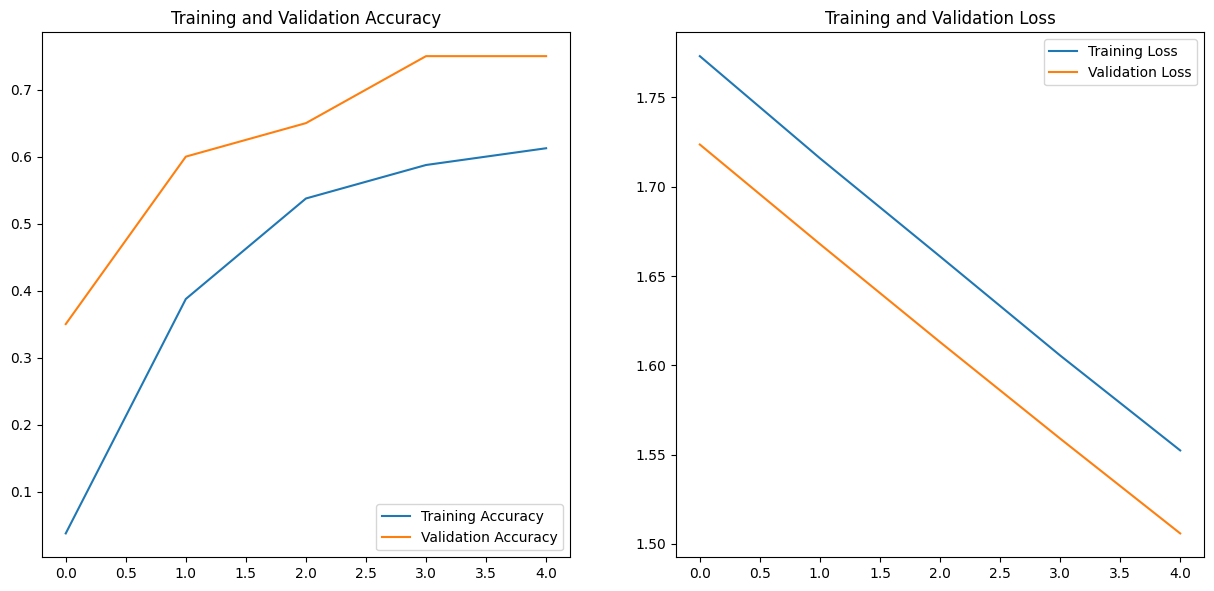

In [14]:
res = load_results()

show_results(res, 0, 5)

NameError: name 'home' is not defined